<a href="https://colab.research.google.com/github/Macbeth1902/PROYECTO_1/blob/main/Pr%C3%A1ctica_2_AAR_Equipo11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Integración de datos (01_merge_data.py)



El código une bases de siniestros y exposición.
Pregunta:

**¿Por qué es fundamental asegurar que la unión (merge) se haga sobre las mismas llaves (por ejemplo, estado, año, ramo)?**


La unión de las bases de Siniestros y Vigor debe realizarse sobre la misma llave que identifica de manera única a los datos de ambas bases. En nuestro caso, la llave con la que identificamos las bases de Siniestros y Vigor es el número de póliza, la cual aparece bajo el nombre de  la columna "NUMPOL". Si utilizamos otra llave como "MONTO", "MARCA" o "ZONA", podríamos asignar siniestros o exposiciones que no corresponden y, de esta manera, distorsionar cálculos de métricas como frecuencia y severidad, que al final son la base para obtener la prima pura de riesgo.


Un ejemplo sería que varias pólizas puedan estar en la misma zona, pero no necesariamente todas tuvieron siniestros. En este caso, unir por zona mezclará información y duplicaría montos o exposiciones. De esta forma, el uso de "NUMPOL" como llave nos garantiza que cada siniestro se asigne a la póliza que realmente lo generó. Como lo habíamos mencionado anteriormente, esto permite obtener cálculos correctos de indicadores como frecuencia y severidad.


En caso de no tener cuidado al elegir la llave con la que se hará la unión, la calidad de la base resultante será muy baja, afectando los cálculos desde un inicio y perdiendo confiabilidad para cualquier análisis que se requiera con la base resultante.



**Explica con un ejemplo qué pasaría si en la base de siniestros aparece un estado que no está en la base de exposición.**

Primero, hay que tomar en cuenta que para unir las bases de datos de siniestros y exposición utilizamos como llave el número de póliza y no el estado. Por lo tanto, en el merge que se presenta en el código, si en la base de siniestros aparece un número de póliza que no se encuentra en la base de exposición, se genera un problema.


En un left join desde exposición hacia siniestros, el cual es el que se utiliza en el código proporcionado, esos siniestros directamente no se incluirían en la unión y se perdería información. En otro caso, si se hubiera utilizado un outer join, los siniestros sí aparecen, pero con exposición vacía, es decir, un valor NaN, lo cual nos causaría problemas al calcular métricas como la frecuencia.


Un ejemplo particular en el cual se utiliza como llave el ESTADO sería el siguiente: Supongamos que en la base de siniestros hay un registro con ESTADO = Oaxaca, pero en la base de exposición solo aparecen pólizas de CDMX y Morelos. El siniestro de Oaxaca quedaría sin información proporcionada por la base de exposición en la unión. Si se ignora (left join), el análisis reportará menos reclamos de los que realmente ocurrieron. Por otra parte, si se incluye pero sin exposición (outer join), al intentar calcular la frecuencia se tendría un problema, el cual se explicará a detalle en la siguiente pregunta.




**¿Cómo afectaría esto al cálculo de la frecuencia?**

La frecuencia la podemos calcular de la siguiente manera:

Frecuencia = Número de Siniestros / Exposición

Si al unir las bases se pierden siniestros por no tener una exposición asociada (en el caso donde utilizamos left join), la frecuencia se subestima, ya que en el numerador faltarían reclamos correspondientes a los valores de siniestros eliminados al no tener un valor de correspondencia en la base de exposición.


Por otra parte, si se incluyen siniestros sin exposición (en el caso donde utilizamos outer join), la frecuencia se vuelve indefinida o exageradamente alta, ya que no podemos dividir entre 0 y tenemos que recurrir a un límite:


Lim Exp -> 0 Frecuencia = Lim Exp -> 0 Número de Siniestros / Exposición = oo

Al tener una frecuencia infinita, nuestro análisis se ve distorsionado y pierde confiabilidad para trabajar con esos resultados.
Un ejemplo sencillo es el siguiente: supongamos que tenemos una póliza con 5 reclamos, pero no aparece en la base de Vigor.


Si calculamos la frecuencia con un left join, esos 5 reclamos no contarían y obtendremos una frecuencia más baja de lo que realmente es.
Si calculamos con un outer join, entonces estaríamos dividiendo entre 0 (exposición vacía), lo que hace imposible interpretar el resultado.


In [2]:
# ============================================
# Tema: Introducción a Pricing y Python
# Autor original: Eric Daniel Hernández Jardón
# Código: Unir base de vigor y siniestros (R → Python)
# ============================================

#%%
import os
import numpy as np
import pandas as pd

# -------------------------------------------------------------------
# 0) Configuración específica para Google Colab con rutas directas
# -------------------------------------------------------------------
# Rutas específicas de los archivos ya subidos
VIGOR_PATH = "/content/vigor.csv"
SINIESTROS_PATH = "/content/siniestros.csv"
DATA_DIR = "/content"

print("=== CONFIGURACIÓN DE RUTAS ===")
print(f"Ruta vigor: {VIGOR_PATH}")
print(f"Ruta siniestros: {SINIESTROS_PATH}")
print(f"Directorio de datos: {DATA_DIR}")

# Verificar que los archivos existen
print("\n=== VERIFICACIÓN DE ARCHIVOS ===")
print(f"vigor.csv existe: {os.path.exists(VIGOR_PATH)}")
print(f"siniestros.csv existe: {os.path.exists(SINIESTROS_PATH)}")

# -------------------------------------------------------------------
# 1) Cargar datos de vigor
# -------------------------------------------------------------------
vigor = pd.read_csv(VIGOR_PATH)

print("\n[vigor cargado correctamente]")
print(f"Dimensiones: {vigor.shape[0]} filas × {vigor.shape[1]} columnas")

print("\n[glimpse(vigor)]")
print(vigor.info())
print("\n[Primeras filas de vigor]:")
print(vigor.head(3))

# Primera verificación general
vigor_summary = pd.DataFrame({
    "polizas": [vigor["NUMPOL"].nunique()],
    "registros": [len(vigor)],
    "expo": [vigor["EXPO"].sum() if "EXPO" in vigor.columns else "Columna EXPO no encontrada"]
})
print("\n[Verificación vigor]")
print(vigor_summary)

# -------------------------------------------------------------------
# 2) Cargar y procesar siniestros
# -------------------------------------------------------------------
siniestros_raw = pd.read_csv(SINIESTROS_PATH)

print("\n[siniestros cargados correctamente]")
print(f"Dimensiones: {siniestros_raw.shape[0]} filas × {siniestros_raw.shape[1]} columnas")

print("\n[glimpse(siniestros)]")
print(siniestros_raw.info())
print("\n[Primeras filas de siniestros]:")
print(siniestros_raw.head(3))

# Primer check
sin_check_1_data = {
    "polizas": [siniestros_raw["NUMPOL"].nunique()],
    "registros": [len(siniestros_raw)]
}

# Verificar columnas opcionales
if "ID" in siniestros_raw.columns:
    sin_check_1_data["id_claim"] = [siniestros_raw["ID"].nunique()]

if "COD_COBERTURA" in siniestros_raw.columns:
    sin_check_1_data["coberturas"] = [siniestros_raw["COD_COBERTURA"].nunique()]
    sin_check_1_data["polizas_cobertura"] = [siniestros_raw[["NUMPOL","COD_COBERTURA"]].drop_duplicates().shape[0]]

sin_check_1 = pd.DataFrame(sin_check_1_data)
print("\n[Primer check siniestros (sin filtros)]")
print(sin_check_1)

# Verificar y procesar columna MONTO
if "MONTO" not in siniestros_raw.columns:
    print("Advertencia: No se encontró la columna 'MONTO'")
    print("Columnas disponibles en siniestros:", siniestros_raw.columns.tolist())
    # Preguntar al usuario qué columna usar como MONTO
    if len(siniestros_raw.columns) > 0:
        # Usar la primera columna numérica como MONTO
        numeric_cols = siniestros_raw.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            monto_col = numeric_cols[0]
            print(f"⚠️ Usando '{monto_col}' como columna MONTO")
            siniestros_raw["MONTO"] = siniestros_raw[monto_col]
        else:
            print("No se encontraron columnas numéricas. Creando MONTO dummy.")
            siniestros_raw["MONTO"] = 0
    siniestros_pos = siniestros_raw.copy()
else:
    # Revisar montos <= 0
    siniestros_le0 = siniestros_raw.query("MONTO <= 0")
    if len(siniestros_le0) > 0:
        print(f"\n[Advertencia] Existen {len(siniestros_le0)} registros con MONTO <= 0 (muestra):")
        print(siniestros_le0[["NUMPOL", "MONTO"]].head(3))
    else:
        print("\n[OK] No hay registros con MONTO <= 0.")

    # Filtrar datos con MONTO > 0
    siniestros_pos = siniestros_raw.query("MONTO > 0").copy()
    print(f"\n[Filtrado MONTO > 0] Registros: {len(siniestros_pos)}")

# Segundo check con datos limpios
sin_check_2_data = {
    "polizas": [siniestros_pos["NUMPOL"].nunique()],
    "registros": [len(siniestros_pos)]
}

if "COD_COBERTURA" in siniestros_pos.columns:
    sin_check_2_data["coberturas"] = [siniestros_pos["COD_COBERTURA"].nunique()]
    sin_check_2_data["id_claim"] = [siniestros_pos[["NUMPOL","COD_COBERTURA"]].drop_duplicates().shape[0]]

sin_check_2 = pd.DataFrame(sin_check_2_data)
print("\n[Segundo check siniestros (MONTO > 0)]")
print(sin_check_2)

# Agregación a nivel póliza-cobertura (si existe COD_COBERTURA)
if "COD_COBERTURA" in siniestros_pos.columns:
    # Detectar duplicados
    dup_mask = siniestros_pos.duplicated(subset=["NUMPOL", "COD_COBERTURA"], keep=False)
    siniestros_dups = siniestros_pos.loc[dup_mask].sort_values(["NUMPOL","COD_COBERTURA"])

    if len(siniestros_dups) > 0:
        print(f"\n[Info] Existen {len(siniestros_dups)} póliza-cobertura con múltiples registros (muestra):")
        print(siniestros_dups[["NUMPOL", "COD_COBERTURA", "MONTO"]].head(3))
    else:
        print("\n[OK] No hay duplicados por póliza-cobertura.")

    # Agregación por póliza y cobertura
    siniestros = (
        siniestros_pos
        .groupby(["NUMPOL","COD_COBERTURA"], as_index=False)
        .agg(MONTO=("MONTO","sum"), num_sin=("MONTO","size"))
    )

    print("\n[Post-agregación siniestros]")
    print(f"Registros después de agregación: {len(siniestros)}")

    # Filtramos cobertura a modelar (ejemplo: "1RC")
    coberturas_disponibles = siniestros["COD_COBERTURA"].unique()
    print(f"\nCoberturas disponibles: {coberturas_disponibles}")

    if "1RC" in coberturas_disponibles:
        siniestros = siniestros.query('COD_COBERTURA == "1RC"').copy()
        print(f"[Filtrado cobertura == '1RC'] Registros: {len(siniestros)}")
    else:
        print(f"'1RC' no encontrado. Usando todas las coberturas.")

else:
    print("No se encontró la columna 'COD_COBERTURA'. Agregando solo por NUMPOL.")
    # Agregación solo por NUMPOL
    siniestros = (
        siniestros_pos
        .groupby(["NUMPOL"], as_index=False)
        .agg(MONTO=("MONTO","sum"), num_sin=("MONTO","size"))
    )

print("\n[Resumen final siniestros procesados]:")
print(f"Polizas únicas: {siniestros['NUMPOL'].nunique()}")
print(f"Registros: {len(siniestros)}")
print(f"Suma de MONTO: {siniestros['MONTO'].sum():.2f}")
# -------------------------------------------------------------------
# 3) Join final
# -------------------------------------------------------------------
print("\n" + "="*50)
print("REALIZANDO JOIN FINAL")
print("="*50)

# Verificar que tenemos datos para hacer el join
if len(vigor) == 0:
    print(" No hay datos en vigor para hacer el join")
    base_trabajo = pd.DataFrame()
elif len(siniestros) == 0:
    print(" No hay datos de siniestros, creando estructura vacía")
    base_trabajo = vigor.copy()
    base_trabajo["MONTO"] = 0.0
    base_trabajo["num_sin"] = 0
else:
    # Left join por NUMPOL
    print(f"Realizando LEFT JOIN: vigor ({len(vigor)} registros) + siniestros ({len(siniestros)} registros)")
    base_trabajo = vigor.merge(siniestros, how="left", on="NUMPOL")
    print(f" Join completado. Resultado: {len(base_trabajo)} registros")

# Validaciones finales
if len(base_trabajo) > 0:
    final_summary_data = {
        "polizas": [base_trabajo["NUMPOL"].nunique()],
        "registros": [len(base_trabajo)]
    }

    if "MONTO" in base_trabajo.columns:
        final_summary_data["MONTO"] = [base_trabajo["MONTO"].sum(skipna=True)]

    if "num_sin" in base_trabajo.columns:
        final_summary_data["num_sin"] = [base_trabajo["num_sin"].sum(skipna=True)]

    final_summary = pd.DataFrame(final_summary_data)
    print("\n[Validación final base_trabajo]")
    print(final_summary)

    # Reemplazar NA por 0
    if "num_sin" in base_trabajo.columns:
        base_trabajo["num_sin"] = base_trabajo["num_sin"].fillna(0).astype(int)
        print("NA en 'num_sin' reemplazados por 0")

    if "MONTO" in base_trabajo.columns:
        base_trabajo["MONTO"] = base_trabajo["MONTO"].fillna(0.0)
        print("NA en 'MONTO' reemplazados por 0.0")

    # Guardar salida
    out_path = os.path.join(DATA_DIR, "base_trabajo.pkl")
    base_trabajo.to_pickle(out_path)
    print(f"\n[Guardado] base_trabajo → {out_path}")

    # Exportar también a CSV
    csv_path = os.path.join(DATA_DIR, "base_trabajo.csv")
    base_trabajo.to_csv(csv_path, index=False, encoding='utf-8')
    print(f"[Guardado] base_trabajo → {csv_path}")

    # Mostrar preview final
    print("\n[Preview final de base_trabajo]:")
    print(base_trabajo.head())

    # Información sobre columnas disponibles
    print(f"\n[Estructura final]:")
    print(f"Columnas: {base_trabajo.columns.tolist()}")
    print(f"Dimensiones: {base_trabajo.shape[0]} filas × {base_trabajo.shape[1]} columnas")

    # Estadísticas básicas
    if "num_sin" in base_trabajo.columns:
        print(f"\n[Estadísticas de siniestros]:")
        print(f"Pólizas con siniestros: {(base_trabajo['num_sin'] > 0).sum()}")
        print(f"Total siniestros: {base_trabajo['num_sin'].sum()}")
        print(f"Frecuencia siniestral: {base_trabajo['num_sin'].sum() / len(base_trabajo):.4f}")

else:
    print("No se pudo crear base_trabajo")

=== CONFIGURACIÓN DE RUTAS ===
Ruta vigor: /content/vigor.csv
Ruta siniestros: /content/siniestros.csv
Directorio de datos: /content

=== VERIFICACIÓN DE ARCHIVOS ===
vigor.csv existe: True
siniestros.csv existe: True

[vigor cargado correctamente]
Dimensiones: 50000 filas × 11 columnas

[glimpse(vigor)]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NUMPOL               50000 non-null  int64  
 1   EXPO                 50000 non-null  float64
 2   ZONA                 50000 non-null  object 
 3   POTENCIA             50000 non-null  int64  
 4   ANTIGUEDAD_VEHICULO  50000 non-null  int64  
 5   EDAD_CONDUCTOR       50000 non-null  int64  
 6   BONO                 50000 non-null  int64  
 7   MARCA                50000 non-null  int64  
 8   COMBUSTIBLE          50000 non-null  object 
 9   DENSIDAD             50000 non

# 2. Modelos lineales y GLM (02_lm_glm.py)

El script compara una regresión lineal y un GLM de Poisson para modelar la frecuencia de siniestros.
Pregunta:

**¿Qué ventaja tiene el GLM con enlace log y offset frente al modelo lineal?**
ce mucho más realista y consistente con el comportamiento de datos de seguros.

El GLM con enlace log y offset permite modelar adecuadamente relaciones no lineales entre predictores y respuesta, especialmente cuando la variable dependiente es un conteo (como número de siniestros) o una magnitud positiva.
En el PDF se ve claramente que el modelo Gaussiano con enlace log (Gauss-Log) y el modelo Poisson con enlace log (Poisson-Log) se ajustan mejor a la forma curvada de los datos del dataset cars, donde a mayor velocidad, la distancia de frenado aumenta de manera no lineal.
El enlace log asegura que las predicciones sean siempre positivas, a diferencia del modelo lineal simple (Gauss-Identity), que para valores bajos de speed predice distancias negativas (ver gráfica "Comparación enlaces Gaussian").
Además, el offset permite incorporar exposición (como años-risk o prima) de manera natural, ajustando por el tamaño del riesgo sin forzar que el intercepto sea cero. Esto es clave en seguros para modelar frecuencias.



**Usando la analogía de los seguros de autos: ¿por qué sería problemático usar un modelo lineal si la variable dependiente es el número de siniestros?**

En seguros de autos, el número de siniestros que reporta un asegurado es un conteo entero que no puede ser negativo. Si se utiliza un modelo lineal, es posible que para ciertas combinaciones de variables explicativas (por ejemplo, edad del conductor o tipo de vehículo) el modelo estime un valor esperado negativo, lo cual es absurdo desde un punto de vista práctico y estadístico. Además, el modelo lineal no respeta la naturaleza discreta de la variable: podría predecir 0.3 o 2.7 siniestros, cifras que carecen de sentido como resultados esperados directos.
Otro problema es que los datos de siniestros suelen ser altamente asimétricos: la mayoría de los asegurados no tienen siniestros en un año, y una minoría tiene uno o más. El modelo lineal no maneja bien esa asimetría ni la relación entre la varianza y la media propia de los conteos (en Poisson, la varianza es proporcional a la media). Por eso, usar un GLM de Poisson con enlace log es mucho más adecuado: garantiza predicciones positivas, enteras en expectativa y con varianzas acordes al fenómeno asegurador.

En seguros de autos, el número de siniestros es una variable de conteo (entera, no negativa) y generalmente con sobredispersión.
El PDF muestra que un modelo Gaussiano (lineal) asume varianza constante, pero en los residuos del modelo aplicado a cars se observa que la dispersión aumenta con la velocidad (heterocedasticidad), algo que también ocurre en siniestralidad: pólizas de mayor riesgo presentan mayor variabilidad.
Si se usa un modelo lineal para conteos, se pueden obtener predicciones negativas (sin sentido) y no se captura la relación varianza-media presente en datos de Poisson o Binomial Negativa.
Además, las gráficas de intervalos de confianza para el modelo Poisson con enlace log muestran una banda que se ensancha de manera más realista conforme aumenta el valor esperado, lo que refleja mejor el comportamiento de la siniestralidad.
Usar un GLM Poisson (o Binomial Negativo) con enlace log resuelve estos problemas: las predicciones son positivas y la estructura de varianza es coherente con la naturaleza de los datos.

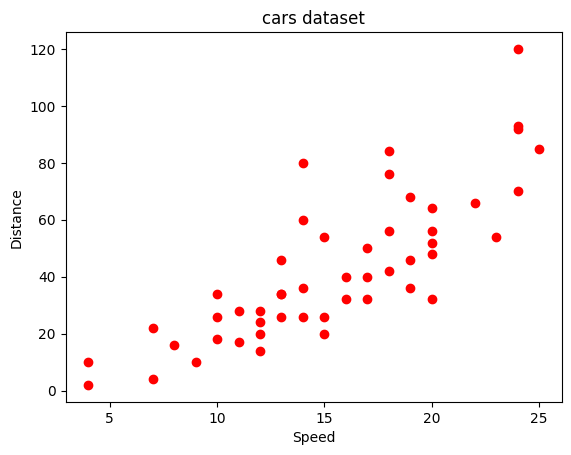

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           1.49e-12
Time:                        05:07:31   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -17.5791      6.758     -2.601      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/usr/local/lib/python3.12/dist-packages/st

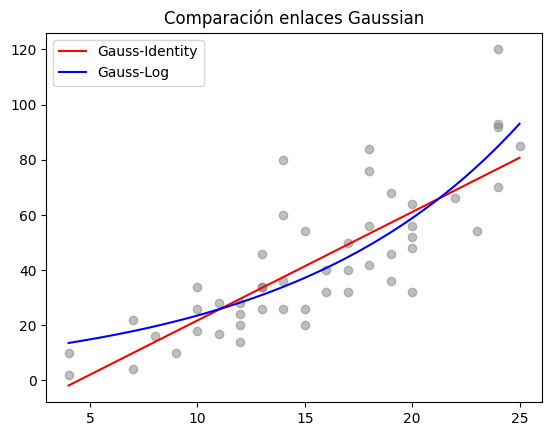

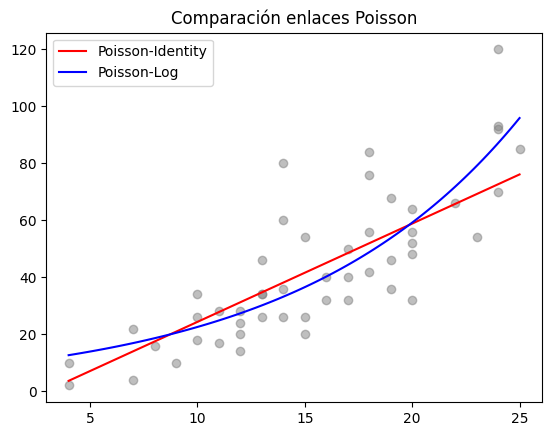

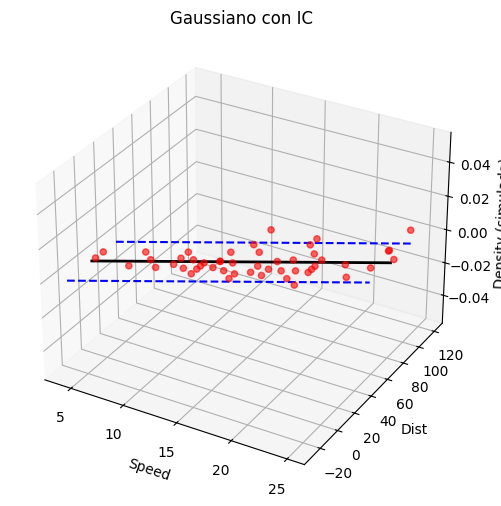

Errores: 4      2.119825
6     -3.744993
8     12.255007
13    -5.609810
29    -9.271854
37    10.863328
36   -11.136672
44   -18.866307
45    -6.798715
49     4.268876
dtype: float64
Densidad normal asociada: [0.02569449 0.02518198 0.01888375 0.02427026 0.02162935 0.02021273
 0.01995741 0.01222357 0.02352507 0.02495948]


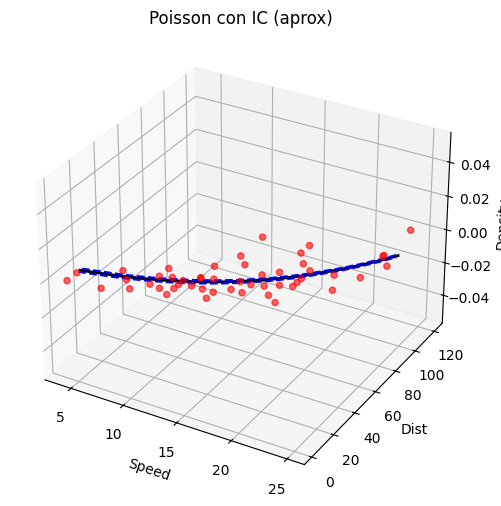

Errores Poisson: 4     -2.596631
6     -4.555642
8     11.444358
13    -3.357483
29    -4.322931
37    14.241220
36    -7.758780
44   -25.084481
45   -17.096707
49   -10.920670
dtype: float64
Densidad Poisson asociada: [0.00000000e+00 0.00000000e+00 4.63517218e-03 0.00000000e+00
 0.00000000e+00 6.95439905e-12 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [3]:
# =========================================================
# Autor: Eric Daniel Hernández Jardón
# Código: Intro a GLM, heterocedasticidad (R → Python)
# Librerías: pandas, numpy, matplotlib, statsmodels
# =========================================================

#%%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm, poisson

# ---------------------------------------------------------
# 0) Datos
# ---------------------------------------------------------
# Dataset "cars" de R → lo replicamos con pandas
from statsmodels.datasets import get_rdataset
cars = get_rdataset("cars").data  # columnas speed, dist

# Scatter simple
plt.scatter(cars["speed"], cars["dist"], c="red")
plt.xlabel("Speed")
plt.ylabel("Distance")
plt.title("cars dataset")
plt.show()

# ---------------------------------------------------------
# 1) Modelos lineales y GLM
# ---------------------------------------------------------
lin_mod = smf.ols("dist ~ speed", data=cars).fit()
print(lin_mod.summary())

gaussian_reg1 = smf.glm("dist ~ speed", data=cars,
                        family=sm.families.Gaussian(sm.families.links.identity())).fit()
print(gaussian_reg1.summary())

gaussian_reg2 = smf.glm("dist ~ speed", data=cars,
                        family=sm.families.Gaussian(sm.families.links.log())).fit()
print(gaussian_reg2.summary())

poisson_reg1 = smf.glm("dist ~ speed", data=cars,
                       family=sm.families.Poisson(sm.families.links.identity())).fit()
print(poisson_reg1.summary())

poisson_reg2 = smf.glm("dist ~ speed", data=cars,
                       family=sm.families.Poisson(sm.families.links.log())).fit()
print(poisson_reg2.summary())

# ---------------------------------------------------------
# 2) Comparación gráfica de gaussian vs poisson
# ---------------------------------------------------------
x_pred = pd.DataFrame({"speed": np.linspace(cars["speed"].min(),
                                            cars["speed"].max(), 100)})

plt.scatter(cars["speed"], cars["dist"], c="grey", alpha=0.5)

for model, color, label in [
    (gaussian_reg1, "red", "Gauss-Identity"),
    (gaussian_reg2, "blue", "Gauss-Log")
]:
    mu = model.predict(x_pred)
    plt.plot(x_pred["speed"], mu, color=color, label=label)

plt.legend()
plt.title("Comparación enlaces Gaussian")
plt.show()

plt.scatter(cars["speed"], cars["dist"], c="grey", alpha=0.5)
for model, color, label in [
    (poisson_reg1, "red", "Poisson-Identity"),
    (poisson_reg2, "blue", "Poisson-Log")
]:
    mu = model.predict(x_pred)
    plt.plot(x_pred["speed"], mu, color=color, label=label)
plt.legend()
plt.title("Comparación enlaces Poisson")
plt.show()

# ---------------------------------------------------------
# 3) Intervalos y dispersión (Gaussiano)
# ---------------------------------------------------------
datos_prueba = pd.DataFrame({"speed": cars["speed"]})
mu_hat = gaussian_reg1.predict(datos_prueba)
phi = gaussian_reg1.scale**0.5  # dispersión

y1 = norm.ppf(0.95, loc=mu_hat, scale=phi)
y2 = norm.ppf(0.05, loc=mu_hat, scale=phi)

# Gráfico 3D tipo "persp"
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cars["speed"], cars["dist"], zs=0, zdir='z', c='red', alpha=0.6)
ax.plot(datos_prueba["speed"], mu_hat, zs=0, zdir='z', color="black", lw=2)
ax.plot(datos_prueba["speed"], y1, zs=0, zdir='z', color="blue", ls="--")
ax.plot(datos_prueba["speed"], y2, zs=0, zdir='z', color="blue", ls="--")

ax.set_xlabel("Speed")
ax.set_ylabel("Dist")
ax.set_zlabel("Density (simulada)")
ax.set_title("Gaussiano con IC")
plt.show()

# ---------------------------------------------------------
# 4) Errores para 10 casos
# ---------------------------------------------------------
np.random.seed(1234)
muestra = np.random.choice(len(cars), size=10, replace=False)
datos_muestra = cars.iloc[muestra].sort_values("speed")

vX = datos_muestra["speed"].values
Y = datos_muestra["dist"].values
mu = gaussian_reg1.predict(datos_muestra)

errores = Y - mu
densidad_errores = norm.pdf(errores, 0, phi)
print("Errores:", errores)
print("Densidad normal asociada:", densidad_errores)

# ---------------------------------------------------------
# 5) Poisson con enlace log
# ---------------------------------------------------------
mu_hat_poi = poisson_reg2.predict(datos_prueba)
# Nota: en R usas qpois, aquí graficamos IC con aproximación normal
phi_poi = poisson_reg2.scale**0.5

y1_poi = norm.ppf(0.95, loc=mu_hat_poi, scale=phi_poi)
y2_poi = norm.ppf(0.05, loc=mu_hat_poi, scale=phi_poi)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cars["speed"], cars["dist"], zs=0, zdir='z', c='red', alpha=0.6)
ax.plot(datos_prueba["speed"], mu_hat_poi, zs=0, zdir='z', color="black", lw=2)
ax.plot(datos_prueba["speed"], y1_poi, zs=0, zdir='z', color="blue", ls="--")
ax.plot(datos_prueba["speed"], y2_poi, zs=0, zdir='z', color="blue", ls="--")

ax.set_xlabel("Speed")
ax.set_ylabel("Dist")
ax.set_zlabel("Density")
ax.set_title("Poisson con IC (aprox)")
plt.show()

# Errores Poisson
errores_poi = Y - poisson_reg2.predict(datos_muestra)
densidad_poi = poisson.pmf(np.round(errores_poi).astype(int), mu)
print("Errores Poisson:", errores_poi)
print("Densidad Poisson asociada:", densidad_poi)

# %%

# 3. Exposición (03_exposicion.py)

Explica con tus palabras qué significa “exposición” en el contexto de un seguro de autos.
La exposición en el contexto de un seguro de automóviles es la proporción en el que una póliza estuvo activa con respecto al tiempo, esta exposición siempre depende del periodo de estudio que se defina, es decir, se escoge previamente desde cuando y hasta cuando se observarán los datos disponibles, y con base a este dato se define cuanto tiempo de cada póliza se estuvo realmente en vigor. La exposición no depende, entonces de la fecha de emisión o de la fecha de vencimiento de la póliza, sino, de la proporción de tiempo que el automóvil asegurado estuvo cubierto.
Por ejemplo, supongamos el caso donde definimos nuestro periodo de estudio desde el 1 de enero de 2025 al 31 de diciembre de 2025, entonces si tenemos los siguientes casos, se tienen las exposiciones correspondientes.

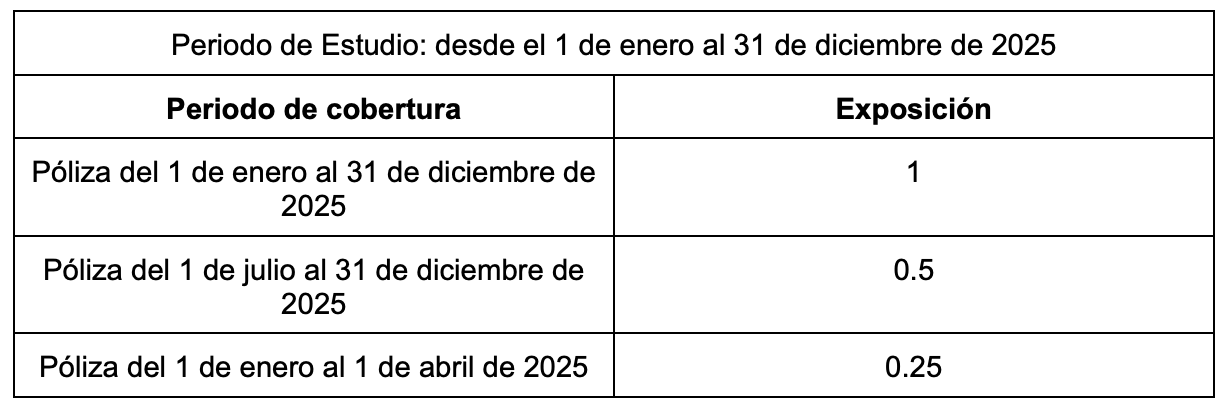


Entonces, a grandes rasgos, la exposición es algo como el “tiempo en riesgo” que se tiene de cada póliza, mientras más tiempo la póliza está activa, es mayor el riesgo acumulado de que le ocurra un siniestro a nuestro automóvil.

Si en tu base algunos asegurados tienen medio año de cobertura y otros el año completo, ¿qué error cometerías si no ajustas por exposición al calcular la frecuencia?

Si no se ajusta por exposición, estaríamos considerando los siniestros totales que fueron presentados, sin considerar que todos los asegurados tuvieron diferentes tiempos donde estuvieron asegurados, lo ideal sería ponderar este promedio por el tiempo que se estuvo expuesto, por ejemplo, supongamos que tenemos lo siguiente en nuestra base de datos:

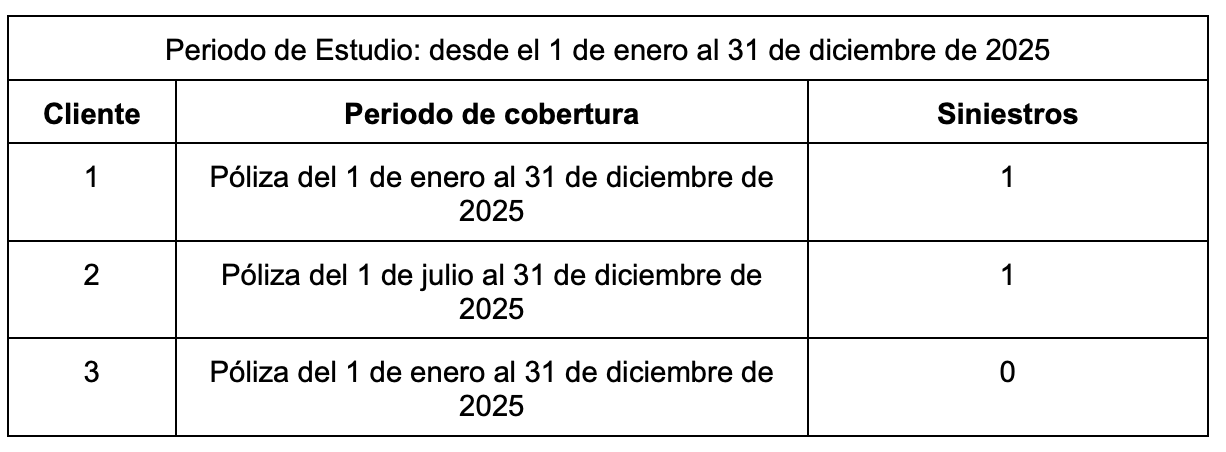

Si calculamos la frecuencia de la siguiente manera:

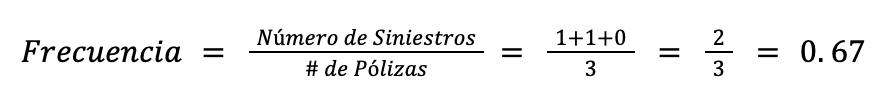

Podríamos notar que cada póliza tiene un riesgo parecido, en cambio, si ajustamos por los años de exposición notamos lo siguiente:

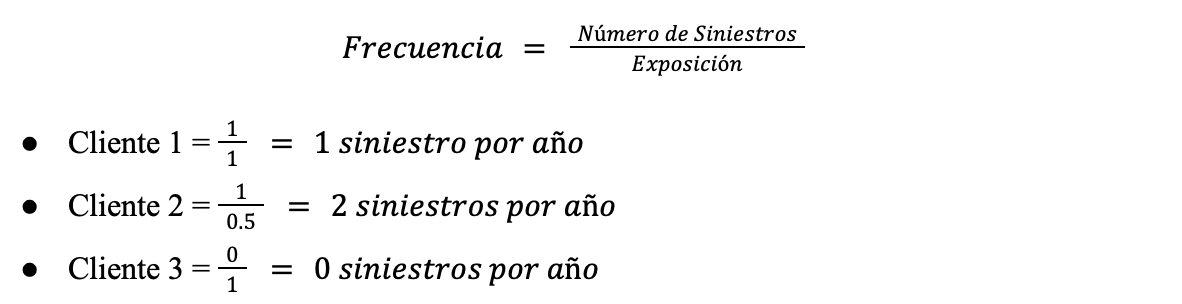

De este modo podemos ver que en realidad el cliente 2 es más riesgoso que los otros dos clientes, pues tuvo más siniestros por año, y la frecuencia ajustada se vería así:

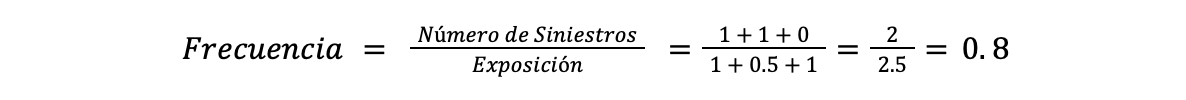

Si no consideramos los años de exposición estaríamos mal estimando la frecuencia, ya sea subestimando o sobreestimando, depende cuál sea el caso.

In [5]:
# =========================================================
# Tema: Introducción a Pricing y Python
# Autor original: Eric Daniel Hernández Jardón
# Código: Exposición en el modelo de frecuencia (simulaciones R → Python)
# Requisitos: numpy, pandas, statsmodels
# =========================================================
#%%
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# ------------------ Utilidades ------------------

def days_diff(end_ts, start_ts) -> int:
    """
    Diferencia (end - start) en días, robusta a tipos (pd.Timestamp o np.datetime64).
    """
    return int((np.datetime64(end_ts, 'ns') - np.datetime64(start_ts, 'ns'))
               / np.timedelta64(1, 'D'))

def trunc_exp_days(rng: np.random.Generator, rate: float) -> int:
    """
    Muestra un tiempo exponencial y lo trunca a entero (>=0).
    Equivalente a trunc(rexp(1, rate)) en R.
    """
    return int(np.floor(rng.exponential(1.0 / rate)))

# ------------------ Parámetros base ------------------

rng = np.random.default_rng(1)    # semilla reproducible
n = 1000                          # pólizas
D1 = pd.Timestamp("2003-01-01")   # inicio observación
D2 = pd.Timestamp("2023-12-31")   # fin observación
mean_gap = 1000.0                 # media de tiempos entre siniestros (días)
rate = 1.0 / mean_gap             # tasa exponencial

# Universo de días para ingreso ~ uniforme en [D1, D2]
L = pd.date_range(D1, D2, freq="D")
ingreso = rng.choice(L, size=n, replace=True)
salida = np.array([D2] * n, dtype="datetime64[ns]")  # base: completas

# ------------------ Escenario 1 ------------------

def sim_siniestros_sin_cancel(ingreso_i, end_i, rng, rate):
    """
    Escenario 1:
    - Sin cancelaciones.
    - Llegadas ~ Exp(rate), truncadas a entero, con +1 día para evitar 0 (como en R: 1 + trunc).
    - Regla de conteo: N = len(w) - 2 (quita el 0 y el último que rompe el ciclo).
    """
    expo_c = days_diff(end_i, ingreso_i)
    w = [0]
    while max(w) < expo_c:
        w.append(w[-1] + 1 + trunc_exp_days(rng, rate))
    N = max(0, len(w) - 2)
    expo = expo_c
    return expo, N

# ------------------ Escenario 2 ------------------

def sim_siniestros_cancela_1500(ingreso_i, end_i, rng, rate, gap_cancel=1500):
    """
    Escenario 2:
    - Cancelación si el mayor gap entre siniestros supera 'gap_cancel' días.
    - En R: while(max(w)<expo_c & max(diff(w))<1500) { w += trunc(exp) }
      Si supera: salida = ingreso + (penúltimo w) + gap_cancel
      Conteo: N = max(0, len(w) - 3).
    """
    expo_c = days_diff(end_i, ingreso_i)
    w = [0, 0]  # para que diff(w) esté definido desde el inicio
    while (max(w) < expo_c) and (np.max(np.diff(w)) < gap_cancel):
        w.append(w[-1] + trunc_exp_days(rng, rate))

    if np.max(np.diff(w)) > gap_cancel:
        # Cancela en ingreso + (penúltimo w) + gap_cancel
        salida_i = pd.Timestamp(ingreso_i) + pd.Timedelta(days=(w[-2] + gap_cancel))
        expo = days_diff(salida_i, ingreso_i)
        N = max(0, len(w) - 3)  # quita 0, el último que rompe, etc.
    else:
        expo = expo_c
        N = max(0, len(w) - 2)
    return expo, N

# ------------------ Escenario 3 ------------------

def sim_siniestros_cancela_50pct_post_claim(ingreso_i, end_i, rng, rate, p_cancel=0.5):
    """
    Escenario 3:
    - Con probabilidad p_cancel, el asegurado cancela inmediatamente después de un siniestro.
    - Interpretación actuarial “natural”: si cancela, la salida = ingreso + (tiempo del último siniestro).
    """
    expo_c = days_diff(end_i, ingreso_i)
    w = [0]
    queda = True
    while (max(w) < expo_c) and queda:
        w.append(w[-1] + trunc_exp_days(rng, rate))
        queda = rng.choice([True, False], p=[1 - p_cancel, p_cancel])
    if not queda:
        # Cancela después del último siniestro
        salida_i = pd.Timestamp(ingreso_i) + pd.Timedelta(days=max(w))
        expo = days_diff(salida_i, ingreso_i)
        N = len(w) - 1  # incluye el siniestro que gatilló la cancelación
    else:
        expo = expo_c
        N = max(0, len(w) - 2)
    return expo, N

# =========================================================
# Simulación y modelos (GLM Poisson con/sin offset) por escenario
# =========================================================

# ---------- Escenario 1 ----------
expo_1 = np.zeros(n, dtype=int)
N_1 = np.zeros(n, dtype=int)
for i in range(n):
    e, c = sim_siniestros_sin_cancel(ingreso[i], salida[i], rng, rate)
    expo_1[i], N_1[i] = e, c

df1 = pd.DataFrame({"E": expo_1 / 365.0, "N": N_1})
# Modelos
reg1_a = smf.glm("N ~ np.log(E)", data=df1, family=sm.families.Poisson()).fit()
reg1_b = smf.glm("N ~ np.log(E)", data=df1,
                 family=sm.families.Poisson(),
                 offset=np.log(df1["E"])).fit()

print("\n=== Escenario 1: sin cancelaciones ===")
print(reg1_a.summary())
print(reg1_b.summary())
print("exp(coef) (con offset):\n", np.exp(reg1_b.params))

# ---------- Escenario 2 ----------
expo_2 = np.zeros(n, dtype=int)
N_2 = np.zeros(n, dtype=int)
for i in range(n):
    e, c = sim_siniestros_cancela_1500(ingreso[i], salida[i], rng, rate, gap_cancel=1500)
    expo_2[i], N_2[i] = e, c

df2 = pd.DataFrame({"E": expo_2 / 365.0, "N": N_2})
reg2_a = smf.glm("N ~ np.log(E)", data=df2, family=sm.families.Poisson()).fit()
reg2_b = smf.glm("N ~ np.log(E)", data=df2,
                 family=sm.families.Poisson(),
                 offset=np.log(df2["E"])).fit()

print("\n=== Escenario 2: cancelación si gap > 1500 ===")
print(reg2_a.summary())
print(reg2_b.summary())
print("exp(coef) (con offset):\n", np.exp(reg2_b.params))

# ---------- Escenario 3 ----------
expo_3 = np.zeros(n, dtype=int)
N_3 = np.zeros(n, dtype=int)
for i in range(n):
    e, c = sim_siniestros_cancela_50pct_post_claim(ingreso[i], salida[i], rng, rate, p_cancel=0.5)
    expo_3[i], N_3[i] = e, c

df3 = pd.DataFrame({"E": expo_3 / 365.0, "N": N_3})
reg3_a = smf.glm("N ~ np.log(E)", data=df3, family=sm.families.Poisson()).fit()
reg3_b = smf.glm("N ~ np.log(E)", data=df3,
                 family=sm.families.Poisson(),
                 offset=np.log(df3["E"])).fit()

print("\n=== Escenario 3: 50% cancelación post-siniestro ===")
print(reg3_a.summary())
print(reg3_b.summary())
print("exp(coef) (con offset):\n", np.exp(reg3_b.params))

# ------------------ Referencias / checks rápidos ------------------

print("\n[Referencia] Esperanza anual por siniestro: 365/1000 =", 365/1000)
print("[Referencia] log(365/1000) =", np.log(365/1000))

# %%




=== Escenario 1: sin cancelaciones ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      N   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1899.5
Date:                Thu, 25 Sep 2025   Deviance:                       1078.2
Time:                        05:09:32   Pearson chi2:                 1.05e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.8001
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

# 4. Segmentación



### Diferencia entre modelar la edad como continua y como factor

Cuando la edad del conductor se modela como variable continua, el GLM asume que la relación entre la edad y la frecuencia de siniestros sigue un patrón lineal o suavemente curvilíneo (dependiendo si se usan polinomios o splines). Este enfoque es parsimonioso y evita sobreajuste, pero puede ser demasiado rígido: no capta comportamientos no lineales bruscos.

Por otro lado, cuando la edad se modela como factor (categórica), cada valor o categoría de edad recibe un parámetro específico. Esto da máxima flexibilidad para detectar diferencias entre grupos de edad, pero puede generar sobreajuste, especialmente si algunas edades tienen poca exposición, además de perder interpretabilidad práctica.

### Ejemplo de segmentación realista en autos

En la práctica actuarial de seguros de autos, no se segmenta cada edad individualmente, sino en rangos de edad. Dos alternativas comunes son:

* Intervalos de 5 años**: 18–22, 23–27, 28–32…
* Intervalos de 10 años**: 18–27, 28–37, 38–47…

Un esquema realista sería agrupar en **rangos de 10 años**, ya que:

* Suaviza la variabilidad estadística (más datos por grupo → mayor credibilidad).
* Mantiene suficiente granularidad para capturar diferencias de riesgo.
* Es fácilmente interpretable para la tarificación y comunicación con áreas comerciales.

### Precisión del modelo vs. interpretabilidad

* **Mayor precisión**: se obtiene con métodos continuos enriquecidos como splines, ya que ajustan la relación no lineal entre edad y siniestralidad, captando picos de riesgo en jóvenes y en adultos mayores.
* **Mayor interpretabilidad**: se alcanza con intervalos de edad (bins). Es sencillo explicar que “los conductores de 18–27 años presentan una frecuencia 40% mayor que los de 38–47 años”.


In [15]:
%pip install pyreadr



[Modelo 0] Tasa global: 0.07279294596542157
                 Generalized Linear Model Regression Results                  
Dep. Variable:                num_sin   No. Observations:                50000
Model:                            GLM   Df Residuals:                    49999
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8175.3
Date:                Thu, 25 Sep 2025   Deviance:                       12680.
Time:                        05:31:51   Pearson chi2:                 9.86e+04
No. Iterations:                     7   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


Frecuencia (edad=40) = 0.072793  IC ≈ [0.069474, 0.076112]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                num_sin   No. Observations:                50000
Model:                            GLM   Df Residuals:                    49998
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8156.6
Date:                Thu, 25 Sep 2025   Deviance:                       12642.
Time:                        05:31:51   Pearson chi2:                 9.68e+04
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0007474
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)
/tmp/ipython-input-4178505490.py:186: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["num_sin"].sum() / g["EXPO"].sum())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                num_sin   No. Observations:                50000
Model:                            GLM   Df Residuals:                    49918
Model Family:                 Poisson   Df Model:                           81
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8093.9
Date:                Thu, 25 Sep 2025   Deviance:                       12517.
Time:                        05:32:01   Pearson chi2:                 9.44e+04
No. Iterations:                    21   Pseudo R-squ. (CS):           0.003251
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                num_sin   No. Observations:                50000
Model:                            GLM   Df Residuals:                    49983
Model Family:                 Poisson   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8132.5
Date:                Thu, 25 Sep 2025   Deviance:                       12594.
Time:                        05:32:02   Pearson chi2:                 9.69e+04
No. Iterations:                    19   Pseudo R-squ. (CS):           0.001712
Covariance Type:            nonrobust                                         
                                                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                num_sin   No. Observations:                50000
Model:                            GLM   Df Residuals:                    49991
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8136.6
Date:                Thu, 25 Sep 2025   Deviance:                       12602.
Time:                        05:32:04   Pearson chi2:                 9.69e+04
No. Iterations:                    19   Pseudo R-squ. (CS):           0.001546
Covariance Type:            nonrobust                                         
                                                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                num_sin   No. Observations:                50000
Model:                            GLM   Df Residuals:                    49993
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8136.9
Date:                Thu, 25 Sep 2025   Deviance:                       12603.
Time:                        05:32:05   Pearson chi2:                 9.69e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.001535
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:985: FutureWarning: linear keyword is deprecated, use which="linear"
  warnings.warn(msg, FutureWarning)


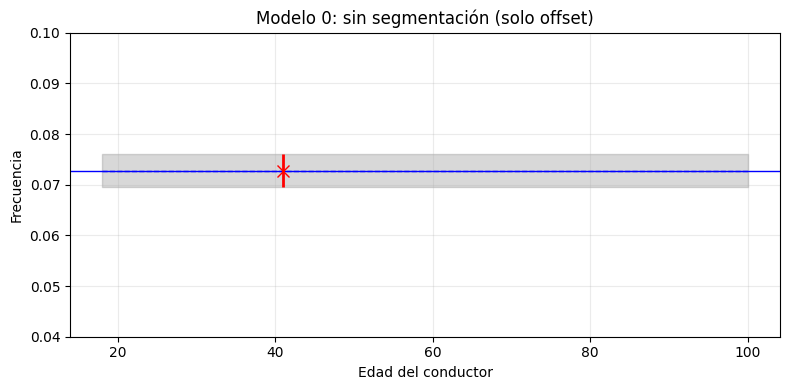

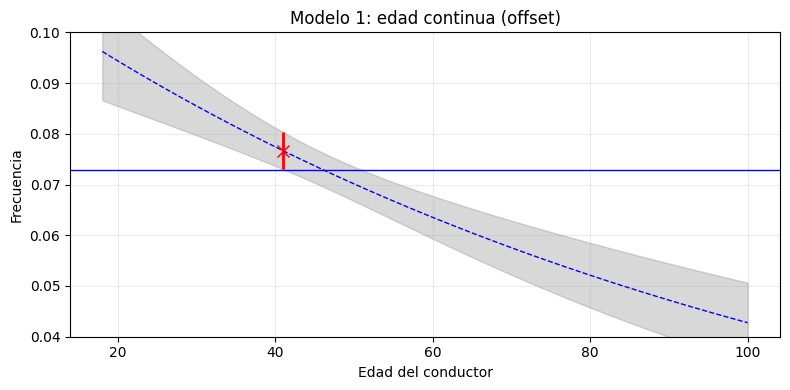

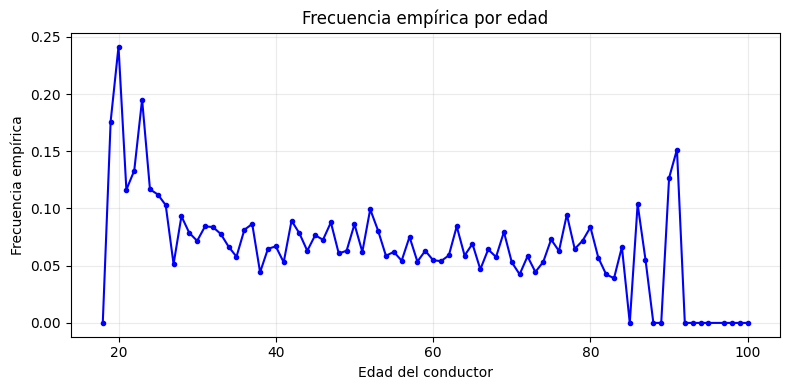

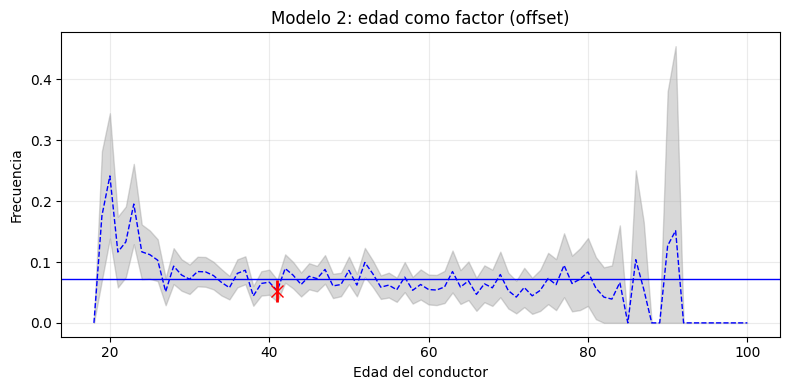

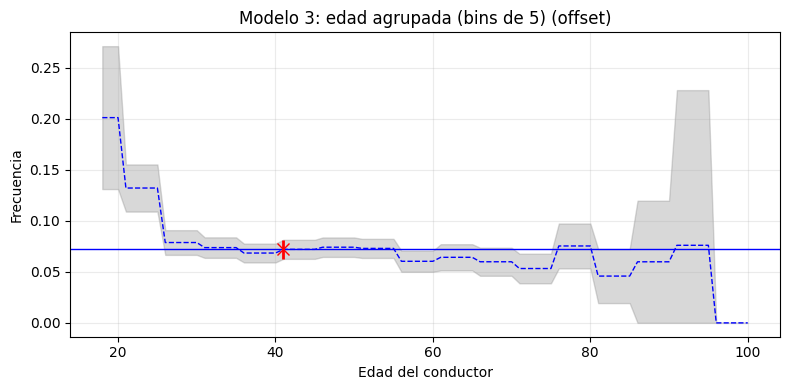

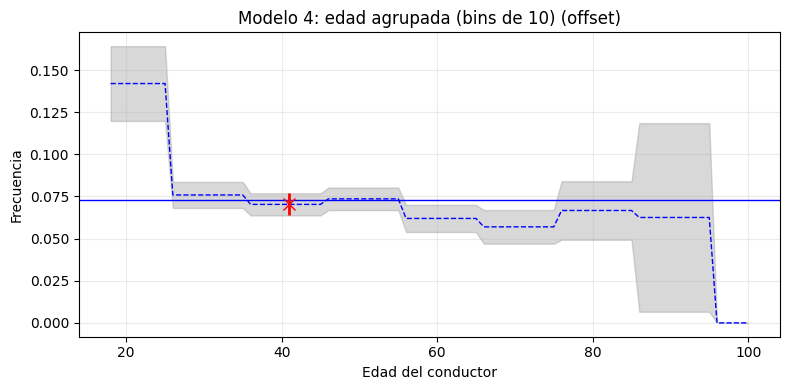

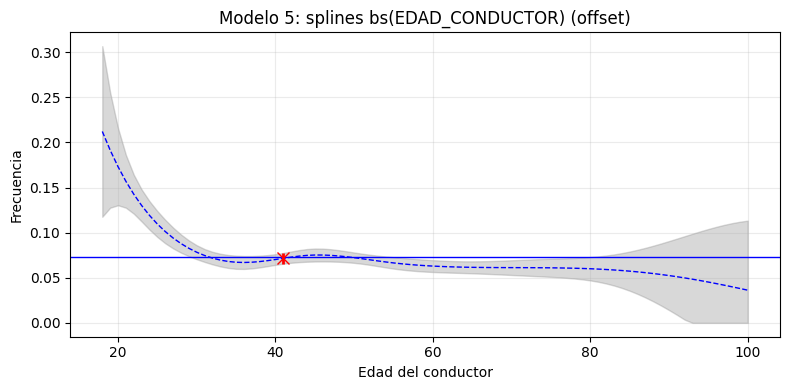

In [25]:
# =========================================================
# Tema: Introducción a Pricing y Python
# Autor original: Eric Daniel Hernández Jardón
# Código: Ventajas de la segmentación (R → Python)
# Requisitos: pandas, numpy, statsmodels, patsy, matplotlib
# =========================================================

#%%
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import build_design_matrices, dmatrix

# (Opcional) para leer RDS si no tienes el PKL:
try:
    import pyreadr
except Exception:
    pyreadr = None

# ---------------------------------------------------------
# 0) Rutas y carga de datos
# ---------------------------------------------------------
try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    BASE_DIR = os.getcwd()

DATA_DIR = os.path.join(BASE_DIR, "data")
pkl_path = "/content/base_trabajo.pkl"
rds_path = os.path.join(DATA_DIR, "base_trabajo.RDS")

if os.path.exists(pkl_path):
    base_trabajo = pd.read_pickle(pkl_path)
elif os.path.exists(rds_path) and pyreadr is not None:
    obj = pyreadr.read_r(rds_path)
    base_trabajo = list(obj.values())[0]
else:
    raise FileNotFoundError(
        f"No encuentro ni {pkl_path} ni {rds_path}. "
        "Genera el PKL con el port previo o instala pyreadr para el RDS."
    )

# Asegura tipos
# base_trabajo["EDAD_CONDUCTOR"] = base_trabajo["EDAD_CONDUCTOR"].astype(int)
# base_trabajo["EXPO"] = base_trabajo["EXPO"].astype(float)

# ---------------------------------------------------------
# Utilidades
# ---------------------------------------------------------
def glm_predict_with_ci(model, new_df, offset_col=None, z=2.0):
    """
    Predicción en GLM con enlace log y bandas ± z*SE mediante delta method.
    Devuelve DataFrame con columnas: mu_hat, mu_lo, mu_hi, se_mu.
    """
    # 1) Construir X_new con la misma design_info (patsy)
    design_info = model.model.data.design_info
    X_new = build_design_matrices([design_info], new_df, return_type='dataframe')[0]
    X_new = np.asarray(X_new, dtype=float)

    # 2) Predicción del predictor lineal eta = Xb + offset
    #    Usamos predict(linear=True) + offset
    if offset_col is not None:
        offset_vals = np.log(new_df[offset_col].values)
    else:
        offset_vals = np.zeros(len(new_df), dtype=float)

    eta_hat = model.predict(new_df, offset=offset_vals, linear=True)

    # 3) Var(eta_hat) = X_new * Cov(beta) * X_new^T (diagonal)
    covb = model.cov_params()
    # diag(X * covb * X^T)
    var_eta = np.einsum('ij,jk,ik->i', X_new, covb, X_new)
    se_eta = np.sqrt(np.maximum(var_eta, 0.0))

    # 4) Delta method para enlace log: mu = exp(eta) => se_mu ≈ mu * se_eta
    mu_hat = np.exp(eta_hat)
    se_mu = mu_hat * se_eta

    mu_hi = mu_hat + z * se_mu
    mu_lo = mu_hat - z * se_mu
    mu_lo = np.clip(mu_lo, a_min=0.0, a_max=None)

    out = pd.DataFrame({
        "mu_hat": mu_hat,
        "mu_lo": mu_lo,
        "mu_hi": mu_hi,
        "se_mu": se_mu
    }, index=new_df.index)
    return out

def plot_pred_bands(x, df_pred, tasa, x_label, y_label, title, k_index=None,
                    ylim=None):
    """
    Gráfico tipo línea con banda (±2·SE), línea horizontal de tasa global,
    y marca en índice k_index.
    """
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x, df_pred["mu_hat"], linestyle="--", color="blue", linewidth=1)
    ax.fill_between(x, df_pred["mu_lo"], df_pred["mu_hi"], color="grey", alpha=0.3)
    ax.axhline(y=tasa, color="blue", linewidth=1)

    if k_index is not None and 0 <= k_index < len(x):
        ax.plot([x[k_index]], [df_pred["mu_hat"].iloc[k_index]],
                marker="x", color="red", markersize=8)
        ax.vlines(x[k_index], df_pred["mu_lo"].iloc[k_index],
                  df_pred["mu_hi"].iloc[k_index], color="red", linewidth=2)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(True, alpha=0.25)
    if ylim is not None:
        ax.set_ylim(*ylim)
    plt.tight_layout()
    return fig, ax

# ---------------------------------------------------------
# 1) Modelo 0 — solo offset (sin segmentación)
# ---------------------------------------------------------
tasa_global = base_trabajo["num_sin"].sum() / base_trabajo["EXPO"].sum()
print("[Modelo 0] Tasa global:", tasa_global)

regglm0 = smf.glm(
    formula="num_sin ~ 1",
    data=base_trabajo,
    family=sm.families.Poisson(),
    offset=np.log(base_trabajo["EXPO"])
).fit()
print(regglm0.summary())

tasa = float(np.exp(regglm0.params["Intercept"]))
print("[Modelo 0] frecuencia asignada a cualquiera (con offset):", tasa)

# Predicciones sobre edades 18..100 con EXPO=1
data1 = pd.DataFrame({"EDAD_CONDUCTOR": np.arange(18, 101), "EXPO": 1.0})
k = 23  # índice 23 ~ edad 40 (porque arranca en 18)

pred0 = glm_predict_with_ci(regglm0, data1, offset_col="EXPO")
fig0, ax0 = plot_pred_bands(
    x=data1["EDAD_CONDUCTOR"].values,
    df_pred=pred0,
    tasa=tasa,
    x_label="Edad del conductor",
    y_label="Frecuencia",
    title="Modelo 0: sin segmentación (solo offset)",
    k_index=k,
    ylim=(0.04, 0.10)  # como en tu ggplot
)

print(f"Frecuencia (edad=40) = {pred0['mu_hat'].iloc[k]:.6f}  "
      f"IC ≈ [{pred0['mu_lo'].iloc[k]:.6f}, {pred0['mu_hi'].iloc[k]:.6f}]")

# ---------------------------------------------------------
# 2) Modelo 1 — EDAD_CONDUCTOR continua
# ---------------------------------------------------------
regglm1 = smf.glm(
    formula="num_sin ~ EDAD_CONDUCTOR",
    data=base_trabajo,
    family=sm.families.Poisson(),
    offset=np.log(base_trabajo["EXPO"])
).fit()
print(regglm1.summary())

pred1 = glm_predict_with_ci(regglm1, data1, offset_col="EXPO")
fig1, ax1 = plot_pred_bands(
    x=data1["EDAD_CONDUCTOR"].values,
    df_pred=pred1,
    tasa=tasa,
    x_label="Edad del conductor",
    y_label="Frecuencia",
    title="Modelo 1: edad continua (offset)",
    k_index=k,
    ylim=(0.04, 0.10)
)

print(f"[M1] Frecuencia (edad=40) = {pred1['mu_hat'].iloc[k]:.6f}  "
      f"IC ≈ [{pred1['mu_lo'].iloc[k]:.6f}, {pred1['mu_hi'].iloc[k]:.6f}]")

# Empírico por edad (para comparar)
emp_edad = (base_trabajo
            .groupby("EDAD_CONDUCTOR", dropna=False)
            .apply(lambda g: g["num_sin"].sum() / g["EXPO"].sum())
            .rename("tasa")
            .reset_index())

fig_emp, ax_emp = plt.subplots(figsize=(8, 4))
ax_emp.plot(emp_edad["EDAD_CONDUCTOR"], emp_edad["tasa"], color="blue", marker="o", ms=3)
ax_emp.grid(True, alpha=0.25)
ax_emp.set_xlabel("Edad del conductor")
ax_emp.set_ylabel("Frecuencia empírica")
ax_emp.set_title("Frecuencia empírica por edad")
plt.tight_layout()

# ---------------------------------------------------------
# 3) Modelo 2 — EDAD_CONDUCTOR categórica (factor)
# ---------------------------------------------------------
# Usamos todas las edades presentes en la base:
data2 = pd.DataFrame({
    "EDAD_CONDUCTOR": np.sort(base_trabajo["EDAD_CONDUCTOR"].unique()),
    "EXPO": 1.0
})

regglm2 = smf.glm(
    formula="num_sin ~ C(EDAD_CONDUCTOR)",
    data=base_trabajo,
    family=sm.families.Poisson(),
    offset=np.log(base_trabajo["EXPO"])
).fit()
print(regglm2.summary())

pred2 = glm_predict_with_ci(regglm2, data2, offset_col="EXPO")
fig2, ax2 = plot_pred_bands(
    x=data2["EDAD_CONDUCTOR"].values,
    df_pred=pred2,
    tasa=tasa,
    x_label="Edad del conductor",
    y_label="Frecuencia",
    title="Modelo 2: edad como factor (offset)",
    k_index=min(k, len(data2)-1),
    ylim=None
)
# Para una versión interactiva (plotly), se podría exportar más adelante.

print(f"[M2] Frecuencia (índice k) = {pred2['mu_hat'].iloc[min(k, len(data2)-1)]:.6f}  "
      f"IC ≈ [{pred2['mu_lo'].iloc[min(k, len(data2)-1)]:.6f}, "
      f"{pred2['mu_hi'].iloc[min(k, len(data2)-1)]:.6f}]")

# ---------------------------------------------------------
# 4) Modelo 3 — EDAD agrupada (cut) en bins de 5 años
# ---------------------------------------------------------
level1 = np.arange(15, 105 + 1, 5)  # 15,20,...,105
base_trabajo["_edad_bin_5"] = pd.cut(
    base_trabajo["EDAD_CONDUCTOR"], bins=level1, right=True, include_lowest=True
)

regglmc1 = smf.glm(
    formula="num_sin ~ C(_edad_bin_5)",
    data=base_trabajo,
    family=sm.families.Poisson(),
    offset=np.log(base_trabajo["EXPO"])
).fit()
print(regglmc1.summary())

# Para predecir en data1 (edades 18..100) con los mismos cortes:
data1["_edad_bin_5"] = pd.cut(
    data1["EDAD_CONDUCTOR"], bins=level1, right=True, include_lowest=True
)
pred3 = glm_predict_with_ci(regglmc1, data1, offset_col="EXPO")
fig3, ax3 = plot_pred_bands(
    x=data1["EDAD_CONDUCTOR"].values,
    df_pred=pred3,
    tasa=tasa,
    x_label="Edad del conductor",
    y_label="Frecuencia",
    title="Modelo 3: edad agrupada (bins de 5) (offset)",
    k_index=k,
    ylim=None
)

print(f"[M3] Frecuencia (edad=40) = {pred3['mu_hat'].iloc[k]:.6f}  "
      f"IC ≈ [{pred3['mu_lo'].iloc[k]:.6f}, {pred3['mu_hi'].iloc[k]:.6f}]")

# ---------------------------------------------------------
# 5) Modelo 4 — EDAD agrupada en bins de 10 años
# ---------------------------------------------------------
level2 = np.arange(15, 105 + 1, 10)  # 15,25,...,105
base_trabajo["_edad_bin_10"] = pd.cut(
    base_trabajo["EDAD_CONDUCTOR"], bins=level2, right=True, include_lowest=True
)

regglmc2 = smf.glm(
    formula="num_sin ~ C(_edad_bin_10)",
    data=base_trabajo,
    family=sm.families.Poisson(),
    offset=np.log(base_trabajo["EXPO"])
).fit()
print(regglmc2.summary())

data1["_edad_bin_10"] = pd.cut(
    data1["EDAD_CONDUCTOR"], bins=level2, right=True, include_lowest=True
)
pred4 = glm_predict_with_ci(regglmc2, data1, offset_col="EXPO")
fig4, ax4 = plot_pred_bands(
    x=data1["EDAD_CONDUCTOR"].values,
    df_pred=pred4,
    tasa=tasa,
    x_label="Edad del conductor",
    y_label="Frecuencia",
    title="Modelo 4: edad agrupada (bins de 10) (offset)",
    k_index=k,
    ylim=None
)

print(f"[M4] Frecuencia (edad=40) = {pred4['mu_hat'].iloc[k]:.6f}  "
      f"IC ≈ [{pred4['mu_lo'].iloc[k]:.6f}, {pred4['mu_hi'].iloc[k]:.6f}]")

# ---------------------------------------------------------
# 6) Modelo 5 — Splines (bs) sobre EDAD_CONDUCTOR
# ---------------------------------------------------------
# En R: bs(EDAD_CONDUCTOR) sin df explícito; aquí usamos df=6 (ajústalo si quieres).
# En statsmodels/patsy: bs(x, df=6, degree=3, include_intercept=False)
regglmc3 = smf.glm(
    formula="num_sin ~ bs(EDAD_CONDUCTOR, df=6)",
    data=base_trabajo,
    family=sm.families.Poisson(),
    offset=np.log(base_trabajo["EXPO"])
).fit()
print(regglmc3.summary())

# Para predecir en data1 se usa la misma interfaz de fórmula (patsy maneja bs)
pred5 = glm_predict_with_ci(regglmc3, data1, offset_col="EXPO")
fig5, ax5 = plot_pred_bands(
    x=data1["EDAD_CONDUCTOR"].values,
    df_pred=pred5,
    tasa=tasa,
    x_label="Edad del conductor",
    y_label="Frecuencia",
    title="Modelo 5: splines bs(EDAD_CONDUCTOR) (offset)",
    k_index=k,
    ylim=None
)

print(f"[M5] Frecuencia (edad=40) = {pred5['mu_hat'].iloc[k]:.6f}  "
      f"IC ≈ [{pred5['mu_lo'].iloc[k]:.6f}, {pred5['mu_hi'].iloc[k]:.6f}]")

plt.show()

# %%

# 5. Dispersión y Elección de Distribución

### La sobredispersión

La **sobredispersión** ocurre cuando la varianza de los datos es mayor que su media.  
Esta es una consideración crítica en modelos de conteo, como el **Poisson**, ya que este último asume que la media es igual a la varianza.  

Esta discrepancia puede llevar a:
- Subestimar los **errores estándar**.  
- Llegar a conclusiones incorrectas sobre la **significancia de las variables**.

---

### Diagnóstico de la Sobredispersión

Para verificar la presencia de sobredispersión, realizamos los siguientes diagnósticos en nuestro código:

**1. Cálculo de la dispersión**  
En el punto 1 del código, la dispersión calculada (varianza / media) es **1.2059**.  
Como este valor es mayor a 1, confirma una **sobredispersión del 20%**, es decir, la varianza excede en promedio a la media en un 20%.

**2. Gráfico de Varianza vs. Media**  
En el punto 2, el gráfico muestra que la mayoría de los datos se encuentran por encima de la línea **y=x**, que representa el escenario ideal del modelo Poisson.  
Esto refuerza visualmente la existencia de sobredispersión.

**3. Ratio de Pearson y Deviance**  
En la sección 4, ajustamos un modelo Poisson para calcular:  
- **Ratio de Pearson:** 1.936 → valor ideal cercano a 1; confirma sobredispersión significativa.  
- **Ratio de Deviance:** 0.2528 → útil, pero el ratio de Pearson es más robusto para este diagnóstico.

---

### Selección del Modelo de Frecuencia

Considerando la **sobredispersión**, evaluamos diferentes modelos para una cartera de autos donde los conductores jóvenes pueden generar alta varianza:

**Poisson**  
- Útil para contar eventos, pero **no es viable** aquí debido a la sobredispersión que afecta la fiabilidad de los resultados.

**Quasi-Poisson**  
- Ajusta los errores estándar con un factor de dispersión, produciendo **valores p más realistas**.  
- **No modela la sobredispersión real**, solo la corrige.

**Zero-Inflated Poisson (ZIP)**  
- Considera un exceso de ceros de dos procesos:  
  1. Poisson normal  
  2. Inflación de ceros (logit)  

- Resultados de nuestro modelo:  
  - `inflate_const`: significativo → hay ceros “extra”.  
  - `inflate_EDAD_CONDUCTOR`: p = 0.111 → la edad no explica los ceros extra.  

- Por lo tanto, este modelo no nos ayudaría a ajustar nuestra conclusión. Aunque sí hay un posible excedente de ceros, el grupo de jóvenes con variabilidad excedente no estaría relacionado con un excedente de ceros en ese grupo.

**Binomial Negativa (NB)**  
- Supone que la varianza es mayor que la media:

$$
\text{Var}(Y) = \mu + \alpha \mu^2
$$


- **α** modela la varianza extra.  
- Resultados:  
  - Edad no significativa: p = 0.349  
  - α = 2.662, p = 0 → ajusta correctamente la **alta sobredispersión**.  

- Conclusión: **El modelo de la Binomial negativa es el modelo más adecuado** para nuestra cartera.



In [29]:
# ============================================
# Tema: Introducción a Pricing y Python
# Autor original: Eric Daniel Hernández Jardón
# Código: Unir base de vigor y siniestros (R → Python)
# Requiere: pandas (>=1.5), numpy
# ============================================
#%%
import os
import numpy as np
import pandas as pd

# -------------------------------------------------------------------
# 0) Configuración de ruta de trabajo (similar a setwd(dir) en R)
# -------------------------------------------------------------------
# Si lo corres como script .py:
try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # Si estás en un notebook, toma el cwd
    BASE_DIR = os.getcwd()

DATA_DIR = os.path.join(BASE_DIR, "data")

# Limpieza de entorno no aplica igual que en R; en Python no es necesario rm(list=ls())

# -------------------------------------------------------------------
# 1) Vigor
# -------------------------------------------------------------------
vigor_path = os.path.join(DATA_DIR, "/content/vigor.csv")
vigor = pd.read_csv(vigor_path)

print("\n[glimpse(vigor)]")
print(vigor.info())
print(vigor.head(3))

# Primera verificación general
vigor_summary = pd.DataFrame({
    "polizas": [vigor["NUMPOL"].nunique()],
    "registros": [len(vigor)],
    "expo": [vigor["EXPO"].sum()]
})
print("\n[Verificación vigor]")
print(vigor_summary)

# -------------------------------------------------------------------
# 2) Siniestros
# -------------------------------------------------------------------
siniestros_path = os.path.join(DATA_DIR, "/content/siniestros.csv")
siniestros_raw = pd.read_csv(siniestros_path)

print("\n[glimpse(siniestros)]")
print(siniestros_raw.info())
print(siniestros_raw.head(3))

# Primer check
sin_check_1 = pd.DataFrame({
    "polizas": [siniestros_raw["NUMPOL"].nunique()],
    "registros": [len(siniestros_raw)],
    "id_claim": [siniestros_raw["ID"].nunique()] if "ID" in siniestros_raw.columns else [np.nan],
    "coberturas": [siniestros_raw["COD_COBERTURA"].nunique()],
    "polizas_cobertura": [siniestros_raw[["NUMPOL","COD_COBERTURA"]].drop_duplicates().shape[0]]
})
print("\n[Primer check siniestros (sin filtros)]")
print(sin_check_1)

# Nunca olvidar este paso: revisar montos <= 0
siniestros_le0 = siniestros_raw.query("MONTO <= 0")
if len(siniestros_le0) > 0:
    print("\n[Advertencia] Existen registros con MONTO <= 0 (muestra):")
    print(siniestros_le0.head(10))
else:
    print("\n[OK] No hay registros con MONTO <= 0.")

# Segundo check con datos limpios (MONTO > 0)
siniestros_pos = siniestros_raw.query("MONTO > 0").copy()
sin_check_2 = pd.DataFrame({
    "polizas": [siniestros_pos["NUMPOL"].nunique()],
    "registros": [len(siniestros_pos)],
    "coberturas": [siniestros_pos["COD_COBERTURA"].nunique()],
    "id_claim": [siniestros_pos[["NUMPOL","COD_COBERTURA"]].drop_duplicates().shape[0]]
})
print("\n[Segundo check siniestros (MONTO > 0)]")
print(sin_check_2)

# Análisis a nivel cobertura: detectar duplicados por NUMPOL, COD_COBERTURA
dup_mask = siniestros_pos.duplicated(subset=["NUMPOL", "COD_COBERTURA"], keep=False)
siniestros_dups = siniestros_pos.loc[dup_mask].sort_values(["NUMPOL","COD_COBERTURA"])
if len(siniestros_dups) > 0:
    print("\n[Info] Existen póliza-cobertura con múltiples registros (muestra):")
    print(siniestros_dups.head(10))
else:
    print("\n[OK] No hay duplicados por póliza-cobertura.")

# Agregación a nivel póliza-cobertura: suma MONTO y cuenta siniestros
siniestros = (
    siniestros_pos
    .groupby(["NUMPOL","COD_COBERTURA"], as_index=False)
    .agg(MONTO=("MONTO","sum"), num_sin=("MONTO","size"))
)

sin_post_agg = pd.DataFrame({
    "polizas": [siniestros["NUMPOL"].nunique()],
    "registros": [len(siniestros)],
    "coberturas": [siniestros["COD_COBERTURA"].nunique()],
    "id_claim": [siniestros[["NUMPOL","COD_COBERTURA"]].drop_duplicates().shape[0]]
})
print("\n[Post-aggregación siniestros]")
print(sin_post_agg)

# Filtramos cobertura a modelar (ejemplo: "1RC")
siniestros = siniestros.query('COD_COBERTURA == "1RC"').copy()
print("\n[Filtrado cobertura == '1RC'] Registros:", len(siniestros))

# -------------------------------------------------------------------
# 3) Join final
# -------------------------------------------------------------------
# Left join por NUMPOL
base_trabajo = vigor.merge(siniestros, how="left", on="NUMPOL")

# Validaciones finales
final_summary = pd.DataFrame({
    "polizas": [base_trabajo["NUMPOL"].nunique()],
    "registros": [len(base_trabajo)],
    "MONTO": [base_trabajo["MONTO"].sum(skipna=True)],
    "num_sin": [base_trabajo["num_sin"].sum(skipna=True)]
})
print("\n[Validación final base_trabajo]")
print(final_summary)

# Revisar nulos en num_sin (no siniestradas)
print("\n[Ejemplo de NUMPOL y num_sin (muestra)]")
print(base_trabajo.loc[:, ["NUMPOL","num_sin"]].head())

# Reemplazar NA por 0 en num_sin (equiv. replace_na de R)
base_trabajo["num_sin"] = base_trabajo["num_sin"].fillna(0).astype(int)

# Guardar salida (equivalente a RDS → usamos pickle por conservar tipos)
out_path = os.path.join(DATA_DIR, "base_trabajo.pkl")
base_trabajo.to_pickle(out_path)
print(f"\n[Guardado] base_trabajo → {out_path}")

# (Opcional) Exportar también a CSV limpio
# base_trabajo.to_csv(os.path.join(DATA_DIR, "base_trabajo.csv"), index=False)

# %%



[glimpse(vigor)]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NUMPOL               50000 non-null  int64  
 1   EXPO                 50000 non-null  float64
 2   ZONA                 50000 non-null  object 
 3   POTENCIA             50000 non-null  int64  
 4   ANTIGUEDAD_VEHICULO  50000 non-null  int64  
 5   EDAD_CONDUCTOR       50000 non-null  int64  
 6   BONO                 50000 non-null  int64  
 7   MARCA                50000 non-null  int64  
 8   COMBUSTIBLE          50000 non-null  object 
 9   DENSIDAD             50000 non-null  int64  
 10  REGION               50000 non-null  int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 4.2+ MB
None
   NUMPOL  EXPO ZONA  POTENCIA  ANTIGUEDAD_VEHICULO  EDAD_CONDUCTOR  BONO  \
0      27  0.87    C         7                    0              56    50   
1 

# 6. Variables relevantes según SESA



Recordemos que en la Práctica 1, nuestro Equipo 11 desarrolló un Seguro contra incendios para comercios de alimentos y abarrotes, el cual corresponde al ramo de Incendios autorizado por la Ley de Instituciones de Seguros y Fianzas, bajo la operación de Daños.

Dado esto, se consultaron los manuales de SESA, a lo que, analizando especialmente el Manual del Sistema Estadístico del Ramo de Incendio (versión 01), resolvimos lo siguiente:


**Identifica al menos tres variables relevantes que deberían formar parte de tu base de datos para pricing.**

Variables relevantes que deben formar parte de la  base de datos para pricing en el ramo de Incendios:

- Suma Asegurada Expuesta
- Giro del Negocio Asegurado
- Entidad/Municipio

En el siguiente cuadro se desarrolla por qué cada una de nuestras variables seleccionadas son influyentes en el pricing de Incendios:


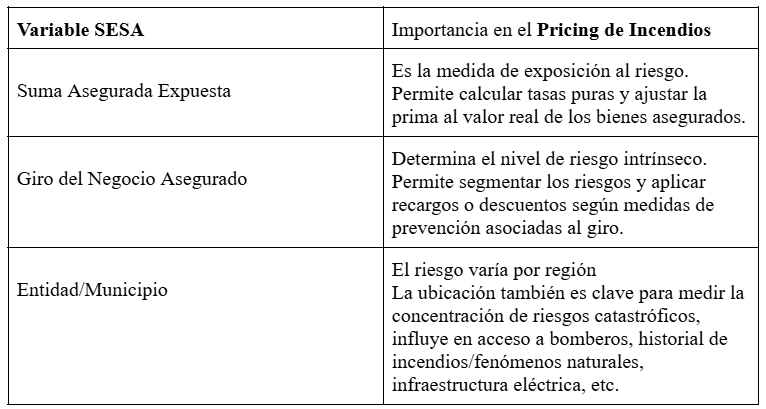

**Justifica por qué son importantes en el cálculo de frecuencia y severidad**

Las 3 variables seleccionadas son importantes en el cálculo de la frecuencia y severidad, esto se justifica en el siguiente cuadro:


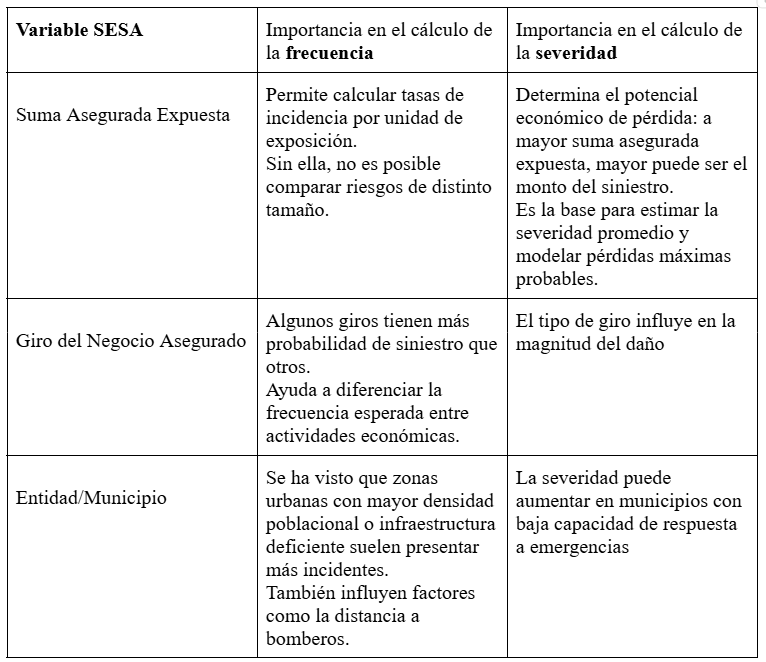

**Reflexiona: ¿qué problemas enfrentarías si dichas variables no estuvieran disponibles?**

Se considera que la falta de alguna de estas variables podría provocar un pricing deficiente y no técnico, se dificultaría el cálculo de frecuencia y el de severidad y se estaría comprometiendo la suficiencia de tarifas, exponiendo a la aseguradora a desequilibrios financieros y selección adversa.


# Bibliografía


- *SISTEMAS INFORMACIÓN ESTADÍSTICA*. (s. f.). https://www.cnsf.gob.mx/Sistemas/Paginas/InformacionEstadistica.aspx
